In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
TRAIN_DATA_DIR = '/content/drive/MyDrive/감정따뜻쟁이/train'
VALIDATION_DATA_DIR = '/content/drive/MyDrive/감정따뜻쟁이/val'

NUM_CLASSES = 4
IMG_WIDTH, IMG_HEIGHT = 224, 224 # VGG16 모델의 기본 이미지 입력 크기
BATCH_SIZE = 32

In [3]:
# 이미지 데이터 생성기
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, #VGG16 모델에 입력하기 위해 이미지를 전처리하는 함수,해당 이미지를 VGG16 모델에 적합한 형태로 전처리
                                   rotation_range=20, # 회전 제한 각도 20도
                                   width_shift_range=0.2, # 좌우이동 20%
                                   height_shift_range=0.2, # 상하이동 20%
                                   zoom_range=0.2 # 확대 축소 20%
                                   )

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # preprocess_input만을 사용하여 이미지를 사전 처리

In [4]:
# 트레이닝 및 검증 데이터셋 생성
train_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_DIR,  # 훈련 데이터셋 경로
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DATA_DIR,  # 검증 데이터셋 경로
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5369 images belonging to 4 classes.
Found 1049 images belonging to 4 classes.


In [5]:
# VGG16 모델 불러오기
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# 기존 레이어의 가중치 동결
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# 새로운 모델 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

In [8]:
# 새로운 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# 모델 훈련
model_hist = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
83/83 [==============================] - 425s 5s/step - loss: 2.4511 - accuracy: 0.3027 - val_loss: 1.4286 - val_accuracy: 0.3291
Epoch 2/10
83/83 [==============================] - 433s 5s/step - loss: 1.3658 - accuracy: 0.3387 - val_loss: 1.3710 - val_accuracy: 0.3633
Epoch 3/10
83/83 [==============================] - 435s 5s/step - loss: 1.3191 - accuracy: 0.3749 - val_loss: 1.4065 - val_accuracy: 0.3291
Epoch 4/10
83/83 [==============================] - 429s 5s/step - loss: 1.3082 - accuracy: 0.3810 - val_loss: 1.3825 - val_accuracy: 0.3555
Epoch 5/10
83/83 [==============================] - 419s 5s/step - loss: 1.2856 - accuracy: 0.3855 - val_loss: 1.4064 - val_accuracy: 0.3242
Epoch 6/10
83/83 [==============================] - 420s 5s/step - loss: 1.2653 - accuracy: 0.4106 - val_loss: 1.3586 - val_accuracy: 0.3350
Epoch 7/10
83/83 [==============================] - 425s 5s/step - loss: 1.2590 - accuracy: 0.4168 - val_loss: 1.3637 - val_accuracy: 0.3330
Epoch 8/10
83

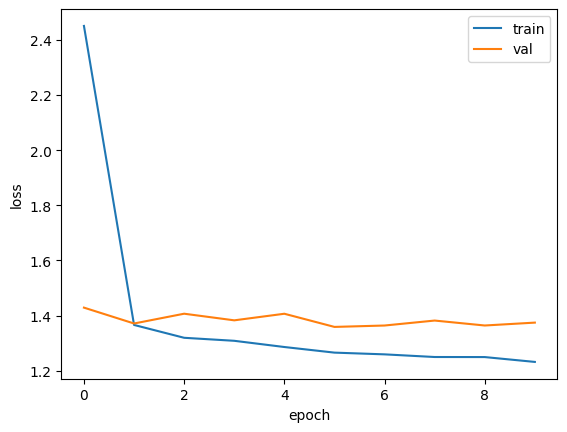

In [11]:
import matplotlib.pyplot as plt
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

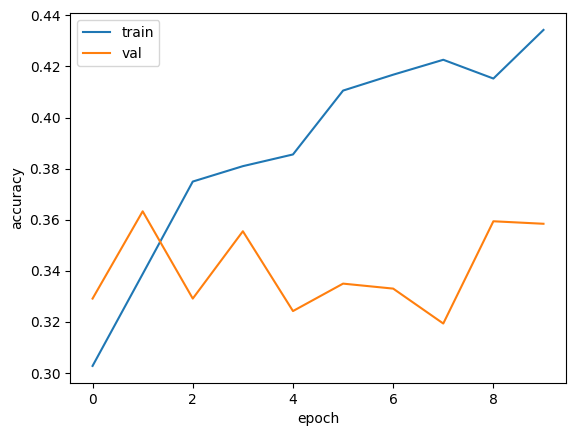

In [14]:
import matplotlib.pyplot as plt
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [16]:
# 감정 예측 확인
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# 새로운 이미지 로드, 전처리, 예측
def predict_image_class(image_path):
    # 이미지 리사이징
    img = load_img(image_path, target_size=(224, 224))
    # 이미지 변환
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 배치 추가
    img_array = preprocess_input(img_array)  # 이미지 전처리
    # 예측 수행
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # [화남: 0, 기쁨: 1, 패닉:2, 슬픔:3]
    classes = ['anger', 'happy', 'panic', 'sadness']

    print(f"prediction result: {classes[predicted_class[0]]} {np.max(predictions) * 100:.2f}%")

# test
image_path = '/content/drive/MyDrive/test_happy.jpg'
predict_image_class(image_path)

1/1 [==============================] - 0s 17ms/step
prediction result: happy 79.69%
